<a href="https://colab.research.google.com/github/Ramprashanth17/AI_Dev_Tools_Zoomcamp_Ram/blob/main/rag-learning-platform/notebooks/1_Embeddings_Fundamentals.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🧬 Semantic Alchemy: The Mathematics of Meaning

### Abstract
Welcome to the foundation of Retrieval-Augmented Generation (RAG). While Large Language Models (LLMs) act as the "reasoning engine," they require a precise retrieval system to function as a "knowledge base." This notebook focuses on building that retriever—the **Librarian**—by mastering **Vector Embeddings**.

In this session, we bridge the gap between human language and machine logic. We will move beyond simple keyword matching and explore how computers understand *context* by converting text into high-dimensional vectors (lists of numbers). Using the `sentence-transformers` library and Gemini, we will:

1.  **Vectorize Thought:** Convert raw text into 384-dimensional embedding vectors.
2.  **Measure Meaning:** Use **Cosine Similarity** to mathematically prove that "puppy" is closer to "dog" than "pizza."
3.  **Visualize the Latent Space:** Project complex high-dimensional relationships into 2D graphs to see how concepts cluster together.

By the end of this notebook, you will have a functioning "Librarian" capable of semantic search, setting the stage for the next critical step: **Chunking**.



### Setting the Project Structure in Google Drive and Integrating with GitHub

I am using colab for this project and hence, I am going to mount my drive and set the project structure. If you're doing this in your local machine you can skip this code.

In [23]:
from google.colab import drive
import os
import sys

# Suppress all output except our prints
import warnings
warnings.filterwarnings('ignore')

# Mount Drive (quietly)
drive.mount('/content/drive', force_remount=False)

repo_path = '/content/drive/MyDrive/Gen_AI'

# Clone if needed
if not os.path.exists(repo_path):
    print("📥 Cloning repository...")
    %cd /content/drive/MyDrive
    !git clone https://github.com/Ramprashanth17/Gen_AI.git --quiet
    print("✅ Cloned!")
else:
    print("✅ Repository found!")

%cd {repo_path}

# Update repo
!git pull origin main --quiet 2>/dev/null

# Create structure
!mkdir -p rag-learning-platform/{notebooks,src/core,src/ui,docs,demo_data,exercises} 2>/dev/null

# Create files (quietly)
with open('rag-learning-platform/README.md', 'w') as f:
    f.write("# RAG Learning Platform\n\nINFO 7390 Final Project\n")

with open('rag-learning-platform/requirements.txt', 'w') as f:
    f.write("sentence-transformers\nchromadb\ngoogle-generativeai\ntiktoken\numap-learn\nplotly\nstreamlit\n")

with open('rag-learning-platform/.gitignore', 'w') as f:
    f.write(".env\n*.pyc\n__pycache__/\n.ipynb_checkpoints/\n*.db\nchroma_db/\n")

# Commit
!git config user.name "Ramprashanth17" 2>/dev/null
!git config user.email "gajarghat.r@northeastern.edu" 2>/dev/null
!git add rag-learning-platform/ 2>/dev/null
!git commit -m "Initialize RAG project" --quiet 2>/dev/null
!git push origin main --quiet 2>/dev/null

print("✅ Setup complete! Ready to build.")
print(f"📂 Location: {repo_path}/rag-learning-platform")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Repository found!
/content/drive/MyDrive/Gen_AI
On branch main
Your branch and 'origin/main' have diverged,
and have 1 and 4 different commits each, respectively.
  (use "git pull" to merge the remote branch into yours)

nothing to commit, working tree clean
✅ Setup complete! Ready to build.
📂 Location: /content/drive/MyDrive/Gen_AI/rag-learning-platform


## 🛠️ Phase 1: Connecting the "Brain" (Generation)

A RAG (Retrieval-Augmented Generation) system needs two distinct types of intelligence working together:

1.  **The Generator (The Mouth):** An LLM that can formulate fluent answers based on information it is given.
2.  **The Retriever (The Librarian):** A system that finds the exact piece of information needed from a large dataset.

In this first step, we are setting up **The Generator**. We will install the Google AI SDK and connect to Gemini.

> **Why Gemini?** We are using `gemini-2.5-flash` because it is optimized for **speed and low latency**. In a RAG system, we want the "reasoning engine" to read our data and answer quickly.

In [24]:
!pip install -q google-generativeai

In [25]:
import google.generativeai as genai
import os

# Set your API key
# GOOGLE_API_KEY = ""  # Replace with your actual key
# genai.configure(api_key=GOOGLE_API_KEY)

# Test it
model = genai.GenerativeModel('gemini-2.5-flash')
response = model.generate_content("Say 'Setup successful!' if you can read this.")
print(response.text)

Setup successful!


## 🧰 Phase 2: Building the "Librarian" (Retrieval)

In [26]:
# Install sentence transformers

!pip install -q sentence-transformers scikit-learn



**🤔 The Big Question: Why do we need this if we already have Gemini?**

This is the key to understanding RAG. We are essentially building a team of two different experts:

1.  **The Writer (Gemini):** This is your reasoning engine. It's brilliant at understanding intent and writing answers, but it is "stateless"—it doesn't know your private data, and it's too slow/expensive to read *your entire database* for every single question.
2.  **The Librarian (Sentence Transformers):** This is a specialized, lightweight system designed for one thing only: **Speed**. It converts text into math (vectors) so we can search through millions of documents in milliseconds to find the *one* relevant paragraph.

**The Workflow:**
The *Librarian* finds the right page; the *Writer* reads it and answers the user.

**Our Toolset:**
* **`sentence-transformers`:** The tool that converts our text into vectors (the "index").
* **`scikit-learn`:** The tool that calculates the mathematical distance between vectors to find the best match.

### 🧠 Loading the Vector Model (`all-MiniLM-L6-v2`)

We aren't training a model from scratch (which takes weeks). Instead, we are downloading a **pre-trained** model that has already read billions of sentences.

* **The Model:** `all-MiniLM-L6-v2`
* **Why this one?** It is a "lightweight" model. It is very fast and produces vectors with **384 dimensions**.
* **What it does:** It takes any text you give it and transforms it into a fixed list of 384 numbers that represent the *meaning* of that text.

In [27]:
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

# Load a pre-trained embedding model
model = SentenceTransformer('all-MiniLM-L6-v2') # 6 transformer layers, 12 attention heads per layer, hidden dimensions: 384 output 384, this number varies as per the model

print("🔬 EXPERIMENT 1: Which of these questions are relevant?")
print("="*50)

# Your three sentences
sentences = [
    "I love dogs",          # A
    "I adore puppies",      # B
    "The weather is sunny"  # C
]

# Convert to embeddings
embeddings = model.encode(sentences)

print(f"\n📊 Each sentence becomes a vector of {len(embeddings[0])} numbers!")
print(f"Sentence A embedding (first 10 numbers): {embeddings[0][:10]}")
print(f"Sentence B embedding (first 10 numbers): {embeddings[1][:10]}")
print(f"Sentence C embedding (first 10 numbers): {embeddings[2][:10]}")

# Calculate similarity scores
similarity_matrix = cosine_similarity(embeddings)

print("\n🎯 SIMILARITY SCORES (0=different, 1=identical):")
print("="*50)
print(f"A ↔ B (dogs vs puppies): {similarity_matrix[0][1]:.4f}")
print(f"A ↔ C (dogs vs weather):  {similarity_matrix[0][2]:.4f}")
print(f"B ↔ C (puppies vs weather): {similarity_matrix[1][2]:.4f}")

print("\n✅ Your intuition was correct! A and B have HIGH similarity")
print("   while C is quite different from both.")

🔬 EXPERIMENT 1: Which of these questions are relevant?

📊 Each sentence becomes a vector of 384 numbers!
Sentence A embedding (first 10 numbers): [-0.03952612 -0.01667648  0.09817863  0.01273901 -0.04502438 -0.01572727
  0.06666625  0.02102092  0.09998433  0.0395087 ]
Sentence B embedding (first 10 numbers): [-0.07700588 -0.03565642  0.05015655  0.05092971 -0.03114847 -0.00157238
  0.06579378  0.00467486  0.06109549  0.06821703]
Sentence C embedding (first 10 numbers): [-0.02564193  0.08108619  0.09214895  0.11154769  0.05551156 -0.0406087
  0.08319418 -0.08164256 -0.0176132  -0.00126704]

🎯 SIMILARITY SCORES (0=different, 1=identical):
A ↔ B (dogs vs puppies): 0.6831
A ↔ C (dogs vs weather):  0.0356
B ↔ C (puppies vs weather): 0.0168

✅ Your intuition was correct! A and B have HIGH similarity
   while C is quite different from both.


In [28]:
 # Visualize embedding space
!pip install -q umap-learn matplotlib

🎨 EXPERIMENT 2: Seeing Embeddings in 2D Space


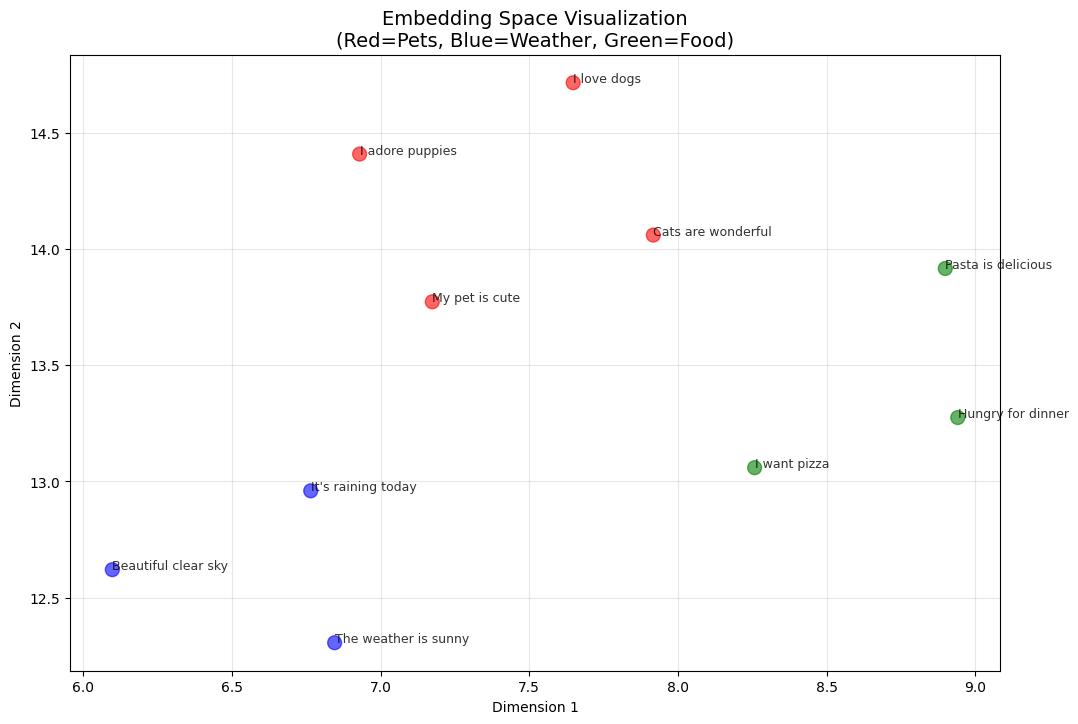


🔍 WHAT DO YOU NOTICE?
Similar topics cluster together in space!


In [29]:
import umap
import matplotlib.pyplot as plt

print("🎨 EXPERIMENT 2: Seeing Embeddings in 2D Space")
print("="*50)

# More sentences to visualize
all_sentences = [
    # Pet cluster
    "I love dogs",
    "I adore puppies",
    "Cats are wonderful",
    "My pet is cute",

    # Weather cluster
    "The weather is sunny",
    "It's raining today",
    "Beautiful clear sky",

    # Food cluster
    "I want pizza",
    "Pasta is delicious",
    "Hungry for dinner"
]

# Get embeddings
all_embeddings = model.encode(all_sentences)

# Reduce 384 dimensions → 2 dimensions (for visualization)
reducer = umap.UMAP(n_components=2, random_state=42)
embeddings_2d = reducer.fit_transform(all_embeddings)

# Plot
plt.figure(figsize=(12, 8))
colors = ['red']*4 + ['blue']*3 + ['green']*3
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=colors, s=100, alpha=0.6)

# Label each point
for i, sentence in enumerate(all_sentences):
    plt.annotate(sentence,
                 (embeddings_2d[i, 0], embeddings_2d[i, 1]),
                 fontsize=9,
                 alpha=0.8)

plt.title("Embedding Space Visualization\n(Red=Pets, Blue=Weather, Green=Food)", fontsize=14)
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.grid(True, alpha=0.3)
plt.show()

print("\n🔍 WHAT DO YOU NOTICE?")
print("Similar topics cluster together in space!")

In [32]:
import plotly.express as px
import pandas as pd

# Create a DataFrame for easier plotting
df = pd.DataFrame(embeddings_2d, columns=['x', 'y'])
df['sentence'] = all_sentences
df['cluster'] = ['Pet'] * 4 + ['Weather'] * 3 + ['Food'] * 3  # Manual clustering for color

# Create interactive plot
fig = px.scatter(
    df,
    x='x', y='y',
    color='cluster',
    hover_data=['sentence'], # Show sentence on hover
    title='Interactive Embedding Space (Hover to read!)',
    template='plotly_dark'
)
fig.update_traces(marker=dict(size=12))
fig.show()

In [30]:
# See how the model represents related words differently

from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

model = SentenceTransformer('all-MiniLM-L6-v2')

print("🐕 EXPERIMENT: Dogs vs Puppies vs Cats")
print("="*60)

# Get embeddings for individual words
words = ["dog", "puppy", "dogs", "puppies", "cat", "kitten", "pizza"]
embeddings = model.encode(words)

# Compare similarities
print("\n📊 SIMILARITY SCORES:")
print("-"*60)

comparisons = [
    ("dog", "puppy"),
    ("dogs", "puppies"),
    ("dog", "cat"),
    ("cat", "kitten"),
    ("dog", "pizza"),
    ("puppy", "kitten"),
]

for word1, word2 in comparisons:
    idx1 = words.index(word1)
    idx2 = words.index(word2)
    sim = cosine_similarity([embeddings[idx1]], [embeddings[idx2]])[0][0]
    print(f"{word1:10} ↔ {word2:10} = {sim:.4f}")

print("\n" + "="*60)
print("🔍 OBSERVATIONS:")
print("- 'dog' and 'puppy' are SIMILAR (but not identical!)")
print("- 'dog' and 'cat' are related (both pets)")
print("- 'puppy' and 'kitten' are similar (both baby animals)")
print("- 'dog' and 'pizza' are UNRELATED (low score)")

🐕 EXPERIMENT: Dogs vs Puppies vs Cats

📊 SIMILARITY SCORES:
------------------------------------------------------------
dog        ↔ puppy      = 0.8040
dogs       ↔ puppies    = 0.7780
dog        ↔ cat        = 0.6606
cat        ↔ kitten     = 0.7882
dog        ↔ pizza      = 0.3530
puppy      ↔ kitten     = 0.6146

🔍 OBSERVATIONS:
- 'dog' and 'puppy' are SIMILAR (but not identical!)
- 'dog' and 'cat' are related (both pets)
- 'puppy' and 'kitten' are similar (both baby animals)
- 'dog' and 'pizza' are UNRELATED (low score)


In [33]:
# 🔍 INTERACTIVE DEMO: The Baby Search Engine
query = "I am hungry"  # <--- Change this to anything, based on our previous ex's!

# 1. Embed the query
query_embedding = model.encode([query])

# 2. Calculate similarity with ALL previous sentences
scores = cosine_similarity(query_embedding, all_embeddings)[0]

# 3. Combine and sort
results = list(zip(all_sentences, scores))
results = sorted(results, key=lambda x: x[1], reverse=True)

print(f"Query: '{query}'\n")
print("Top Matches:")
print("-" * 30)
for sentence, score in results:
    # Visual progress bar for similarity
    bar = "█" * int(score * 20)
    print(f"{score:.4f} | {bar:<20} | {sentence}")

Query: 'I am hungry'

Top Matches:
------------------------------
0.7086 | ██████████████       | Hungry for dinner
0.5227 | ██████████           | I want pizza
0.4203 | ████████             | Pasta is delicious
0.2757 | █████                | My pet is cute
0.2495 | ████                 | I love dogs
0.2419 | ████                 | Cats are wonderful
0.2042 | ████                 | It's raining today
0.2040 | ████                 | I adore puppies
0.1999 | ███                  | Beautiful clear sky
0.1139 | ██                   | The weather is sunny


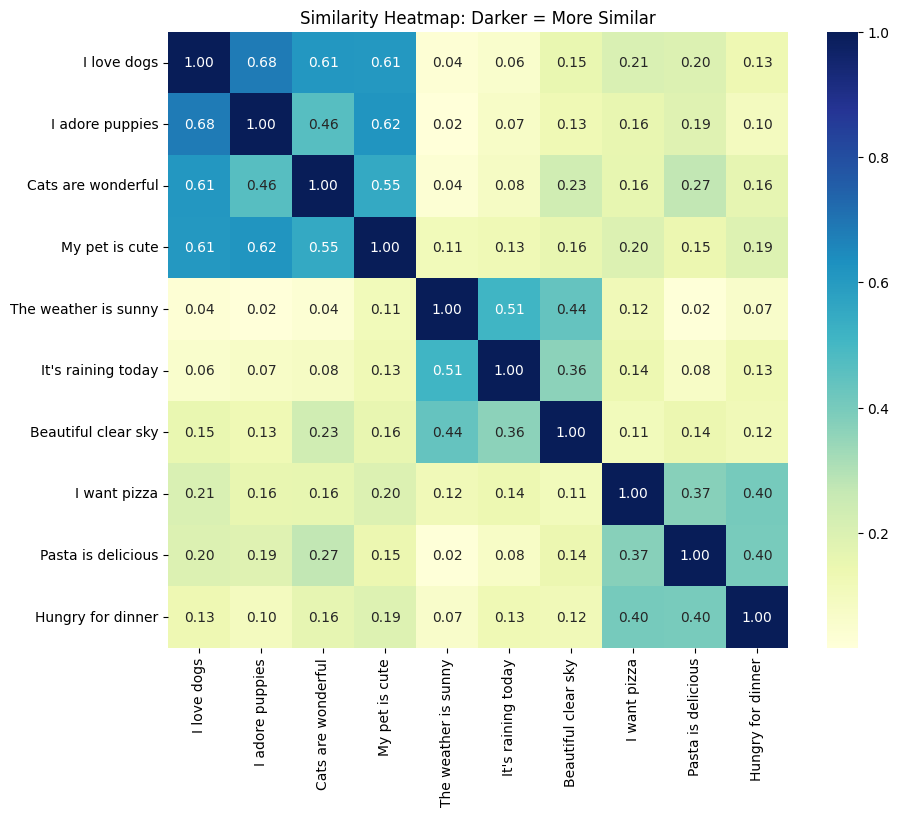

In [34]:
import seaborn as sns

# Create a Similarity Heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(
    cosine_similarity(all_embeddings),
    xticklabels=all_sentences,
    yticklabels=all_sentences,
    cmap="YlGnBu",
    annot=True,       # Show the numbers
    fmt=".2f"
)
plt.title("Similarity Heatmap: Darker = More Similar")
plt.show()

In [38]:
# 🎓 YOUR TURN: Try to trick the model!
# 1. Change the query below to something tricky like "frozen water"
# 2. Run the cell. Does it match "It's raining today" or "I want pizza"?

my_query = "I would like to take my dog out for a walk"

# --- No need to change code below ---
my_embedding = model.encode([my_query])
scores = cosine_similarity(my_embedding, all_embeddings)[0]
best_match_idx = np.argmax(scores)

print(f"Your Query: '{my_query}'")
print(f"Best Match: '{all_sentences[best_match_idx]}' (Score: {scores[best_match_idx]:.4f})")

Your Query: 'I would like to take my dog out for a walk'
Best Match: 'My pet is cute' (Score: 0.3670)


## 🧩**Process-1: Understanding Embeddings: From Text to Numbers**

### **The Problem We're Solving**
Computers are number crunching machines at its core. Then, how are they able to have a conversation with us now? how are the LLMs able to understand, comprehend and return us an output that is solving our problems be it code, information, etc?

Let's dig into the history a bit. We sure came a long way from punch cards to Python, we've been building better ways to
communicate with computers. Now, with LLMs, we can use plain English!
But here's the puzzle: how does a machine understand that "dog" and "puppy" are similar when it only knows binary? That's where embeddings come in.

It's like we drove from manual transmission cars to automatic transmission cars and then gradually progressing towards self-driving cars!


### **What Are Embeddings?**
Embeddings are a way to convert text into numbers that capture meaning. Think of them like GPS coordinates for words - except instead of 2 numbers (latitude, longitude), we use 384 numbers to capture all the nuances of language: sentiment, topic, grammar, context, and more.
When you feed a sentence into an embedding model, it returns a fixed list of 384 numbers called a **vector**. Similar sentences get similar number patterns!  

### **How the Model Creates Embeddings?**
The model we're using **(all-MiniLM-L6-v2)** was pre-trained on billions of sentences. During training, it learned that words appearing in similar contexts (like "dog" and "puppy" both appearing after "walk the...") probably have similar meanings.
When you give it text, it instantly converts it:

- "I love dogs" → [0.234, 0.891, 0.123, ..., 0.456] (384 numbers)

- "I adore puppies" → [0.289, 0.843, 0.167, ..., 0.412] (similar pattern!)

- "The weather is nice" → [0.891, 0.234, 0.678, ..., 0.123] (different pattern!)

**Key point:** Each sentence is converted independently. The model doesn't compare them - it just converts text to numbers.

### **Finding Similar Text**
Once we have embeddings, we use **cosine similarity** to measure how similar two texts are. It compares the direction of the vectors in 384-dimensional space (imagine 3D space, but with 381 more dimensions!).
The score ranges from -1 to 1:

- Near 1: Very similar (e.g., "dog" ↔ "puppy" = 0.89)
- Near 0: Unrelated (e.g., "dog" ↔ "weather" = 0.12)
- Negative: Opposite meanings (rare in practice)

***Visual intuition:*** In the 2D plots you saw earlier, sentences about pets cluster together, weather forms another cluster, and food forms a third. That's the 384-dimensional space compressed into 2D!

### **Common Misconceptions**
There might be some doubts arising like I had when I was learning this like:

- ❓ "How do similar words get similar numbers?"

The model learned this during training by reading billions of examples. It noticed that "dog" and "puppy" appear in similar contexts, so it assigns them similar embeddings. This happened during training - now the model just applies what it learned.

- ❓ "Do embeddings change?"

The same text always produces the same embedding. "I love pizza" will always give you the exact same 384 numbers, no matter when you convert it. The embeddings are deterministic and don't change based on other sentences.

-  ❓ "Does punctuation have a fixed value?"

No. Context is everything! You might think that a symbol like "!" always maps to the exact same list of numbers. That was actually true for older AI models (like looking up a word in a static dictionary), but the model we are using (Sentence Transformer) is **Contextual**.

It calculates the vector based on the *entire sentence* at once. The "!" symbol changes its mathematical representation depending on how it is used:

* **"Wow!"** (Here, the vector for "!" reflects *excitement*).
* **"Stop!"** (Here, the vector for "!" reflects a *command*).
* **"if x != y"** (Here, the vector for "!" reflects *logic/math*).

**The Takeaway:** The model doesn't just assign a number to a character; it assigns numbers to the *meaning* of that character in that specific moment.

-  ❓ "Does the number of words in an input sentence impacts the numbers present in the vector?"

No! Regardless of how long or short the sentence is the model gives out an embedding of a fixed vector value of 384 numbers in a vector (for this model!). Why? because the cosine rule needs fixed size of embeddings.

This problem is the intro for our next process **Chunking!**
